In [1]:
from combine.libraries import *
from combine.modelling_qsar import QSAR
from combine.qsar_evidence_combinator import QSAR_Single_Evidence, QSAR_Evidence_Combinator

### Import data for modelling

In [2]:
pradeep_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_pradeep_train.sdf"
hansen_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_hansen_train.sdf"
hakura_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_hakura_train.sdf"

ames_test = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_test.sdf"

In [3]:
t = PandasTools.LoadSDF(os.path.join(RDConfig.RDDataDir, ames_test),molColName='molecule', includeFingerprints=True)

### Build models

To initiate the QSAR class, the molecule and result columns must have the following names "molecule" and "result", respectively.

In [4]:
from sklearn.ensemble import RandomForestClassifier

# initiate class
Ames_RF = QSAR(hansen_ames)

# compute descriptors for modelling
Ames_RF.compute_descriptors('MolecularDescriptors')

# build model 
Ames_RF.model(model=RandomForestClassifier(random_state=28, n_estimators = 700,min_samples_split=10,min_samples_leaf=3, max_features='sqrt', max_depth=100, bootstrap=False))

# return reliability with prior
Ames_RF_reliability = Ames_RF.get_performance(prior=0.35)

# return prediction for the test
Ames_RF_prediction = Ames_RF.predict_proba(ames_test)

INFO - Computing MolecularDescriptors for uploaded training dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 6178/6178 [01:08<00:00, 90.44it/s]


INFO - Building model...
INFO - Returning updated model performance considering prior probability...
INFO - Computing MolecularDescriptors for uploaded test dataset...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 93.73it/s]

INFO - Predicting percent probability for the test series...


In [5]:
import xgboost as xgb

# initiate class
Ames_XGBOOST = QSAR(pradeep_ames)

# compute descriptors for modelling
Ames_XGBOOST.compute_descriptors('MorganFingerprints')

# build model 
Ames_XGBOOST.model(model=xgb.XGBClassifier(gamma = 0, learning_rate = 0.1, max_depth = 6, min_child_weigh = 1, n_estimators=100, verbosity = 0, silent=True,subsample=1, random_state = 28))

# return reliability with prior
Ames_XGBOOST_reliability = Ames_XGBOOST.get_performance(prior=0.4)

# return prediction for the test
Ames_XGBOOST_prediction = Ames_XGBOOST.predict_proba(ames_test)

INFO - Computing MorganFingerprints for uploaded training dataset...


100%|████████████████████████████████████████████████████████████████████████████| 2086/2086 [00:00<00:00, 3067.56it/s]


INFO - Building model...
INFO - Returning updated model performance considering prior probability...
INFO - Computing MorganFingerprints for uploaded test dataset...


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1200.89it/s]

INFO - Predicting percent probability for the test series...


In [6]:
from sklearn import svm

Ames_SVM = QSAR(hakura_ames)

# compute descriptors for modelling
Ames_SVM.compute_descriptors('PhysChemProperties')

# build model 
Ames_SVM.model(model=svm.SVC(C=100, kernel='rbf',gamma='auto', probability=True))

# return reliability with prior
Ames_SVM_reliability = Ames_SVM.get_performance()

# return prediction for the test
Ames_SVM_prediction = Ames_SVM.predict_proba(ames_test)

INFO - Computing PhysChemProperties for uploaded training dataset...


100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 578.42it/s]


INFO - Building model...
INFO - Returning model evaluation metrics ...
INFO - Computing PhysChemProperties for uploaded test dataset...


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 853.40it/s]

INFO - Predicting percent probability for the test series...


### Single class objects

In [7]:
RF = QSAR_Single_Evidence(identifier= 'RF', prediction=Ames_RF_prediction, reliability=Ames_RF_reliability, relevance='certain')
XGBOOST = QSAR_Single_Evidence(identifier= 'XGBOOST', prediction=Ames_XGBOOST_prediction, reliability=Ames_XGBOOST_reliability,relevance='certain')
SVM = QSAR_Single_Evidence(identifier= 'SVM', prediction=Ames_SVM_prediction, reliability=Ames_SVM_reliability, relevance='certain', weight = 3)

INFO - Processing evidence from model identified as "RF"...
INFO - Processing evidence from model identified as "XGBOOST"...
INFO - Processing evidence from model identified as "SVM"...


### Further examples for single class objects

In [8]:
RF.test(test_set=t)
RF.ids

0    13114-72-2
1       86-57-7
2      583-39-1
3     2185-92-4
4    32425-83-5
5       98-37-3
Name: ID, dtype: object

In [9]:
RF.qsar_show_components(selection='BPA')

Showing the basic probability assignments of provided evidence...


,Negative,Uncertain,Positive
ID,,,
13114-72-2,0.632821,0.167235,0.199943
86-57-7,0.107366,0.287232,0.605402
583-39-1,0.580615,0.179158,0.240228
2185-92-4,0.089414,0.291331,0.619255
32425-83-5,0.150998,0.277268,0.571734
98-37-3,0.667999,0.159202,0.172799


Showing the belief and plausibility for outcomes associated with provided evidence...


,Belief (Negative),Plausibility (Negative),Belief (Positive),Plausibility (Positive)
ID,,,,
13114-72-2,0.632821,0.800057,0.199943,0.367179
86-57-7,0.107366,0.394598,0.605402,0.892634
583-39-1,0.580615,0.759772,0.240228,0.419385
2185-92-4,0.089414,0.380745,0.619255,0.910586
32425-83-5,0.150998,0.428266,0.571734,0.849002
98-37-3,0.667999,0.827201,0.172799,0.332001


In [10]:
RF.qsar_show_components(selection='BP')

Showing the basic probability assignments of provided evidence...


,Negative,Uncertain,Positive
ID,,,
13114-72-2,0.632821,0.167235,0.199943
86-57-7,0.107366,0.287232,0.605402
583-39-1,0.580615,0.179158,0.240228
2185-92-4,0.089414,0.291331,0.619255
32425-83-5,0.150998,0.277268,0.571734
98-37-3,0.667999,0.159202,0.172799


Showing the belief and plausibility for outcomes associated with provided evidence...


,Belief (Negative),Plausibility (Negative),Belief (Positive),Plausibility (Positive)
ID,,,,
13114-72-2,0.632821,0.800057,0.199943,0.367179
86-57-7,0.107366,0.394598,0.605402,0.892634
583-39-1,0.580615,0.759772,0.240228,0.419385
2185-92-4,0.089414,0.380745,0.619255,0.910586
32425-83-5,0.150998,0.428266,0.571734,0.849002
98-37-3,0.667999,0.827201,0.172799,0.332001


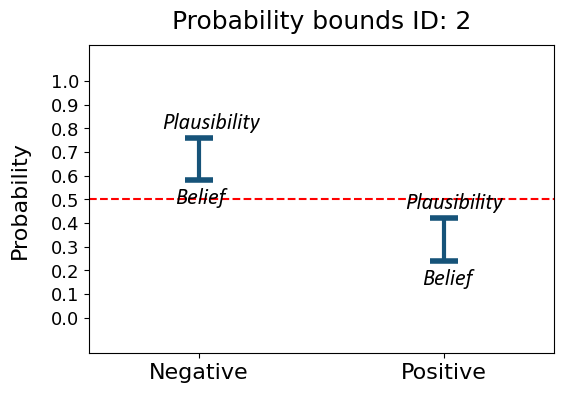

In [11]:
RF.qsar_visualise_single_evidence(compound = 2, visualise_threshold = 0.5)

### Multiple evidence class

In [12]:
Ames_models = QSAR_Evidence_Combinator('Ames mutagenicity')

INFO - QSAR Evidence Combinator initiated for the endpoint "Ames mutagenicity"...


In [13]:
Ames_models.add_evidence(RF)
Ames_models.add_evidence(XGBOOST)
Ames_models.add_evidence(SVM)

INFO - Adding evidence from QSAR model with identifier RF ...
INFO - Adding evidence from QSAR model with identifier XGBOOST ...
INFO - Adding evidence from QSAR model with identifier SVM ...


In [14]:
Ames_models.upload_test(test_set=t)

INFO - Test set defined...


In [15]:
Ames_models.combination(rule_selection=None, WoE=True)

INFO - Considering individual weights of evidence...
INFO - Computing ground probability masses...
INFO - Combining evidence...
INFO - No rule selected, combining evidence using all rules...


In [16]:
Ames_models.return_results(mol='583-39-1')

,Negative,Uncertain,Positive
RF,0.580615,0.179158,0.240228
XGBOOST,0.543617,0.210718,0.245665
SVM,0.517150,0.482850,0.000000
Dempster,0.963506,0.007198,0.029296
Yager,0.568873,0.413830,0.017297


INFO - Showing results for: 583-39-1


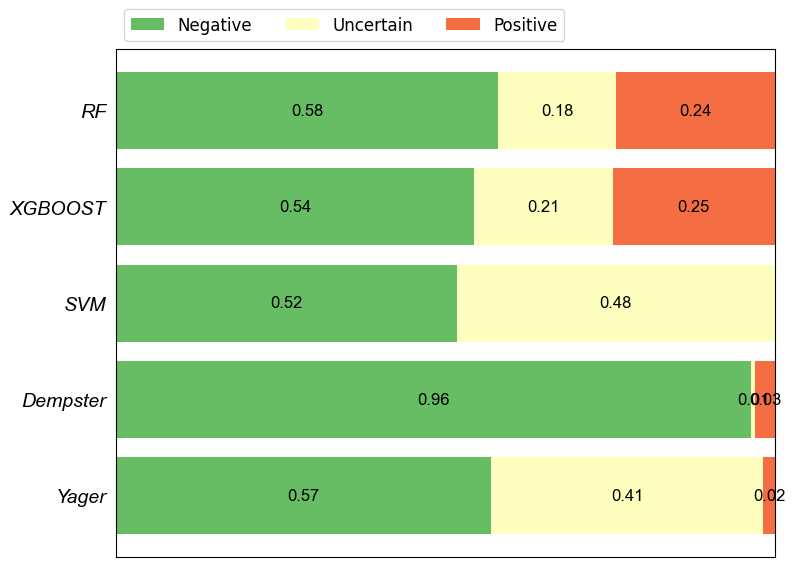

In [17]:
Ames_models.visualise(mol='583-39-1')